In [1]:
# Key Takeaways from part 1:
# 1.) Initializing the NN values as roughly gaussian well helps avoid the wasteful 
#     hockey stick part of the training, which would just squash the numbers to smaller 
#     values over 1000s of iterations
# 2.) Scale the Weights and Biases at initialization to get much better reaults
# 3.) For deeper neural nets scaling the Ws and bs is hard, therefore we use
#     normalization layers, we used Batch Normalization
#     other layers are: Group Normalization, Layer Normalization

# Key Takeaways from part 2:
# 1.) Batch Normalization helps make deeper neural networks more robust to misconfigured initializations
# 2.) Pytorch-ification of the code, start learning the structure
# 3.) Introduced diagnostic tools (4 charts) that can help identify misconfigured hyperparameters

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary of characters and mappins to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):
    X, Y = [], []
    for w in words:
        # print(w)

        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y
    
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])       # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte, Yte = build_dataset(words[n2:])   # 10%

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [7]:
# MLP revisited
n_embd = 10 # the dimensionality of the character embedding vectors
n_hidden = 200 # the number of neurons in the hidden layer of the MLP

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd),             generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3) / ((n_embd * block_size)**0.5) # Kaiming initialization: https://pytorch.org/docs/stable/nn.init.html
#b1 = torch.randn(n_hidden,                        generator=g) * 0.01
W2 = torch.randn((n_hidden,vocab_size),           generator=g) * 0.01
b2 = torch.randn(vocab_size,                      generator=g) * 0

# BatchNorm parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

# parameters = [C, W1, b1, W2, b2, bngain, bnbias]
parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

12097


tensor(0.0013) tensor(1.0022)
tensor(-0.0053) tensor(1.0122)


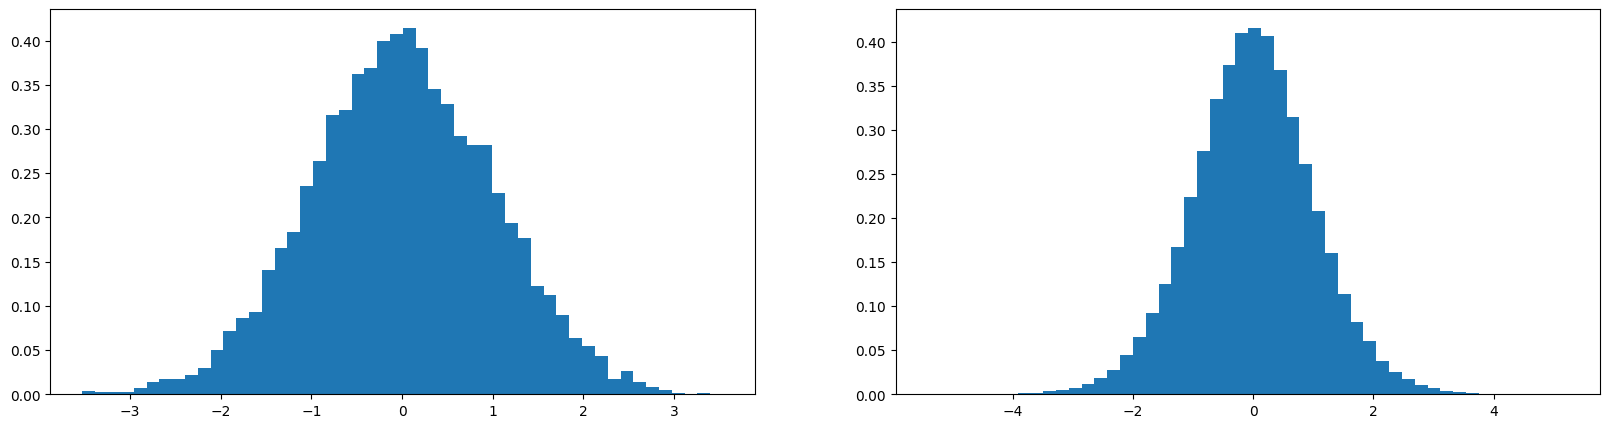

In [44]:
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True);
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True);

In [11]:
hpreact.shape

torch.Size([32, 200])

In [12]:
hpreact.mean(0, keepdim=True).shape

torch.Size([1, 200])

In [13]:
hpreact.std(0, keepdim=True).shape

torch.Size([1, 200])

In [15]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
epsilon = 1e-5

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb, = Xtr[ix], Ytr[ix] # # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    embcat = emb.view(emb.shape[0], -1) # concatenate the vectors
    # Linear Layer
    hpreact = embcat @ W1 #+ b1 # hidden layer pre-activation
    # BatchNorm Layer (https://arxiv.org/pdf/1502.03167.pdf)
    # --------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True) + epsilon
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
    with torch.no_grad():
        bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi
    # --------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0198
 190000/ 200000: 2.1707


In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest') # White is true, black is false

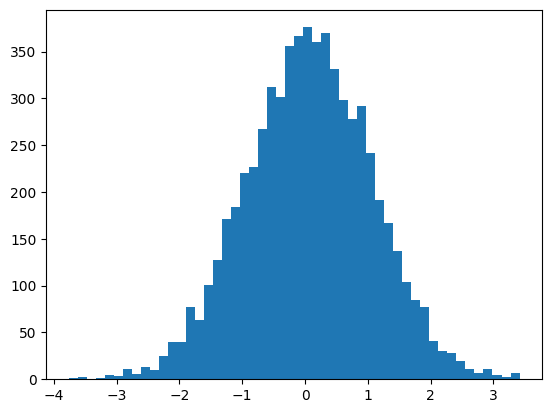

In [18]:
plt.hist(hpreact.view(-1).tolist(), 50);

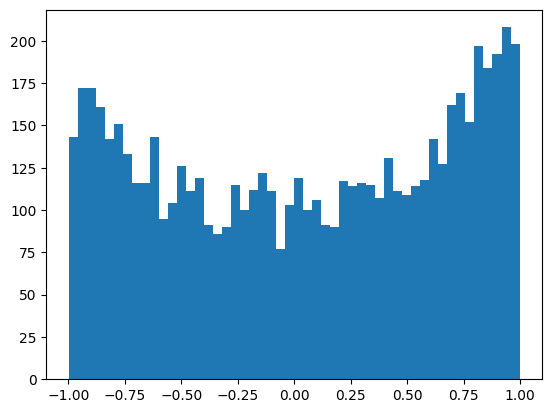

In [19]:
plt.hist(h.view(-1).tolist(), 50);

In [71]:
# Another Important takeaway: At initialization check the initial output values and try to produce somewhat uniform probabilities
# Otherwise we'll have too high losses, and the training cycles will be spent on just squashing down the high losses
logits[0]

tensor([ -2.3527,  36.4366, -10.7306,   5.7165,  18.6409, -11.6998,  -2.1991,
          1.8535,  10.9996,  10.6730,  12.3507, -10.3809,   4.7243, -24.4257,
         -8.5909,   1.9024, -12.2744, -12.4751, -23.2778,  -2.0163,  25.8767,
         14.2108,  17.7691, -10.9204, -20.7335,   6.4560,  11.1615],
       grad_fn=<SelectBackward0>)

In [67]:
# 4-dimensional example of the issue
# logits = torch.tensor([0.0, 0.0, 0.0, 0.0])
logits = torch.randn(4) * 10
probs = torch.softmax(logits, dim=0)
loss = -probs[2].log()
logits, probs, loss

(tensor([-9.2825,  4.6303, -3.7695, -4.2702]),
 tensor([9.0700e-07, 9.9964e-01, 2.2484e-04, 1.3628e-04]),
 tensor(8.4001))

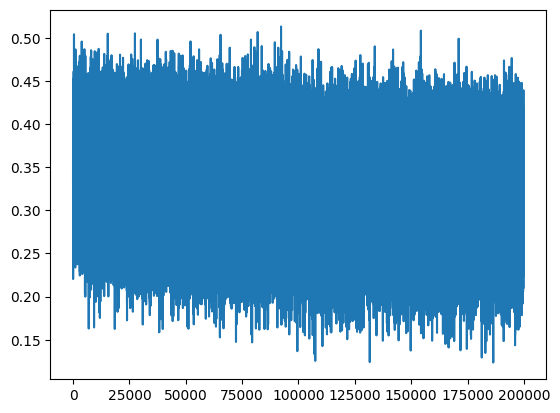

In [15]:
plt.plot(lossi)

In [16]:
# calibrate the batch norm at the end of trainning

with torch.no_grad():
    # pass the training set through
    emb = C[Xtr]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bnstd = hpreact.std(0, keepdim=True)

In [32]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1) # concat into (N, block_size * n_embd)
    hpreact = embcat @ W1 + b1 # hidden layer pre-activation
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact) # (N, h_hidden)
    logits = h @ W2 + b2 # (N, vocab_size)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())
    
split_loss('train')
split_loss('val')

train 2.0439891815185547
val 2.0963029861450195


In [18]:
#sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        #forward pass the neural net
        emb = C[torch.tensor([context])] # (1, block_size, n_embd)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        # sample from the distribution
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        #shift the context window and track the samples
        context = context[1:] + [ix]
        out.append(ix)
        # break if we get .
        if ix == 0:
            break
            
    print(''.join(itos[i] for i in out)) # decode and print the generated word

catth.
fatth.
qulfirrnziqlatyssncfssteffzontef.
prsthc.
prqeifnnkmaritch.
div.
briefgyd.
bmanvitte.
qunnsslyverishbbi.
wraerkgiefryxiidh.
sulipsables.
fgicpsette.
jasfayramasmbul.
sussadnbellsozswy.
bjumillasrahndelfsadlusofforgstky.
falryndra.
prlmanraq.
shelseombriyabh.
syld.
qwuftobbifphz.


In [133]:
# ------------------------------ SUMMARY ------------------------------

In [8]:
# Let's train a deeper network

class Linear:
    
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None
        
    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])
    
class BatchNorm1d:
    
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []
    
n_embd = 10 # dimensionality of the character embedding vectors
n_hidden = 100 # the number of neurons in the hidden layer of the MLP
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator = g)
layers = [
    Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(           n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
    # last layer: make less confident
    layers[-1].gamma *= 0.1
    # layers[-1].weight *= 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 5/3
            
parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

47551


In [16]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb, = Xtr[ix], Ytr[ix] # # batch X, Y

    # forward pass
    emb = C[Xb] # embed the characters into vectors
    x = emb.view(emb.shape[0], -1) # concatenate the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # backward pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain_grad
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    lr = 0.1 if i < 100000 else 0.01 
    for p in parameters:
        p.data += -lr * p.grad
        
    # track stats
    if i%10000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr*p.grad.std() / p.data.std()).log10().item() for p in parameters])
    
    # if i >= 1000:
    #     break # AFTER_DEBUG: would take out obviously to run full optimization

      0/ 200000: 2.6473
  10000/ 200000: 2.2728
  20000/ 200000: 2.2837
  30000/ 200000: 1.9429
  40000/ 200000: 2.0733
  50000/ 200000: 2.0503
  60000/ 200000: 1.7421
  70000/ 200000: 2.0898
  80000/ 200000: 2.2811
  90000/ 200000: 1.8946
 100000/ 200000: 1.8947
 110000/ 200000: 1.8448
 120000/ 200000: 1.8117
 130000/ 200000: 1.8818
 140000/ 200000: 1.9568
 150000/ 200000: 2.1607
 160000/ 200000: 2.3224
 170000/ 200000: 2.3192
 180000/ 200000: 1.8130
 190000/ 200000: 1.7700


layer 2 (Tanh): mean -0.02, std 0.67, saturation 15.09%
layer 5 (Tanh): mean -0.02, std 0.71, saturation 15.78%
layer 8 (Tanh): mean +0.01, std 0.74, saturation 16.34%
layer 11 (Tanh): mean +0.02, std 0.78, saturation 15.25%
layer 14 (Tanh): mean -0.01, std 0.80, saturation 17.97%


Text(0.5, 1.0, 'activation distribution')

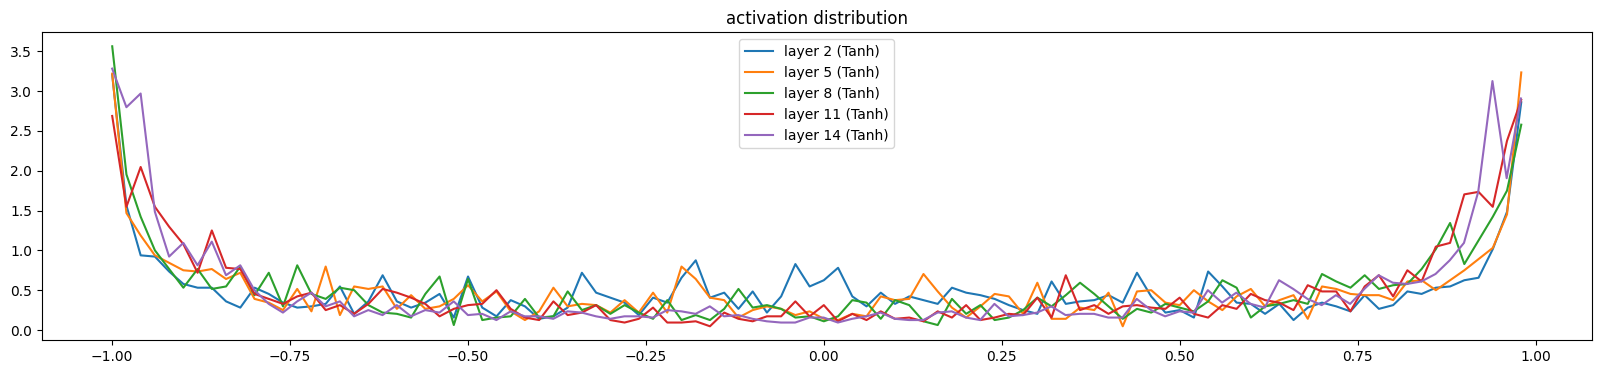

In [17]:
# visualize histograms
plt.figure(figsize=(20, 4)) # with and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():+.2f}, std {t.std():.2f}, saturation {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('activation distribution')

layer 2 (Tanh): mean +0.000000, std 5.363935e-03
layer 5 (Tanh): mean -0.000000, std 4.359030e-03
layer 8 (Tanh): mean +0.000000, std 3.949881e-03
layer 11 (Tanh): mean -0.000000, std 4.034238e-03
layer 14 (Tanh): mean +0.000000, std 4.513101e-03


Text(0.5, 1.0, 'gradient distribution')

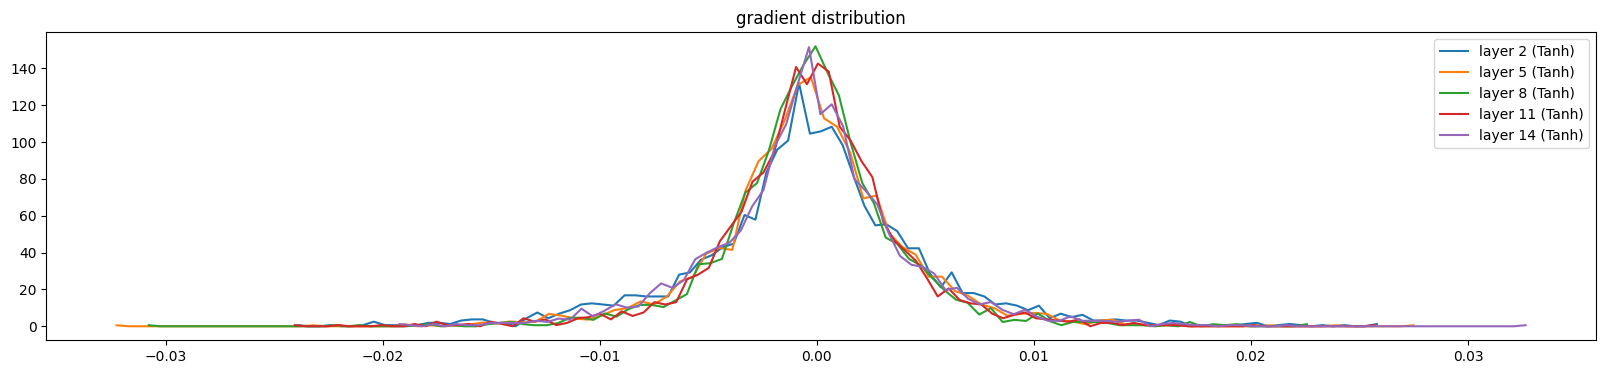

In [18]:
# visualize histograms
plt.figure(figsize=(20, 4)) # with and height of the plot
legends = []
for i, layer in enumerate(layers[:-1]): # note: exclude output layer
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():+f}, std {t.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('gradient distribution')

weight (27, 10) | mean +0.000000 | std 2.604207e-02 | grad:data ratio 2.382237e-02
weight (30, 100) | mean -0.000381 | std 1.150185e-02 | grad:data ratio 2.800474e-02
weight (100, 100) | mean +0.000097 | std 6.730254e-03 | grad:data ratio 2.720158e-02
weight (100, 100) | mean -0.000100 | std 6.448408e-03 | grad:data ratio 2.650028e-02
weight (100, 100) | mean +0.000073 | std 6.202518e-03 | grad:data ratio 2.612852e-02
weight (100, 100) | mean +0.000022 | std 5.899570e-03 | grad:data ratio 2.560674e-02
weight (100, 27) | mean +0.000094 | std 1.206249e-02 | grad:data ratio 3.641269e-02


Text(0.5, 1.0, 'weights gradient distribution')

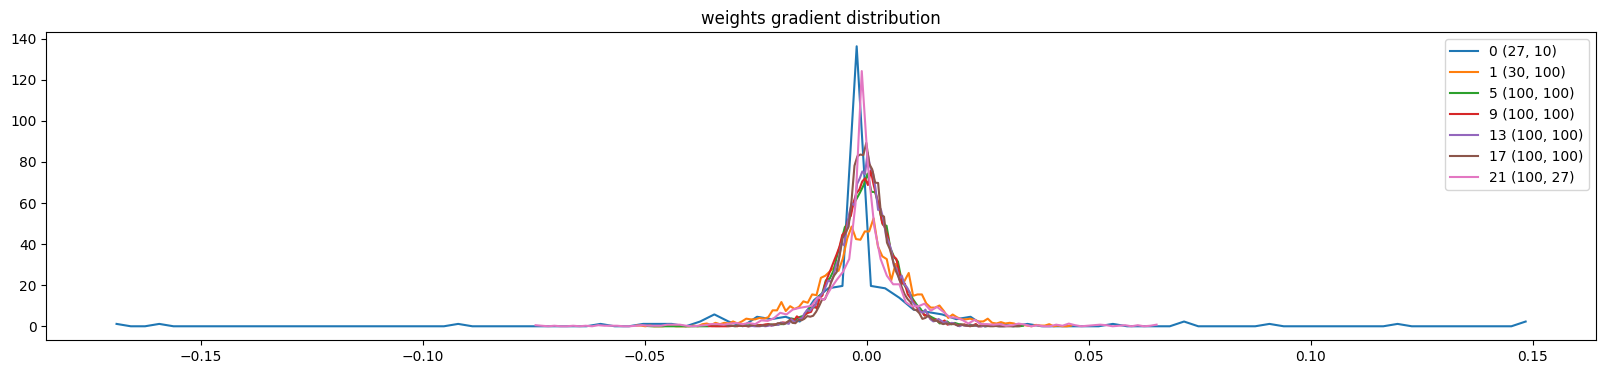

In [19]:
# visualize histograms
plt.figure(figsize=(20, 4)) # with and height of the plot
legends = []
for i,p in enumerate(parameters):
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)} | mean {t.mean():+f} | std {t.std():e} | grad:data ratio {t.std()/p.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'{i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('weights gradient distribution')

Text(0.5, 1.0, 'log10 updates to data')

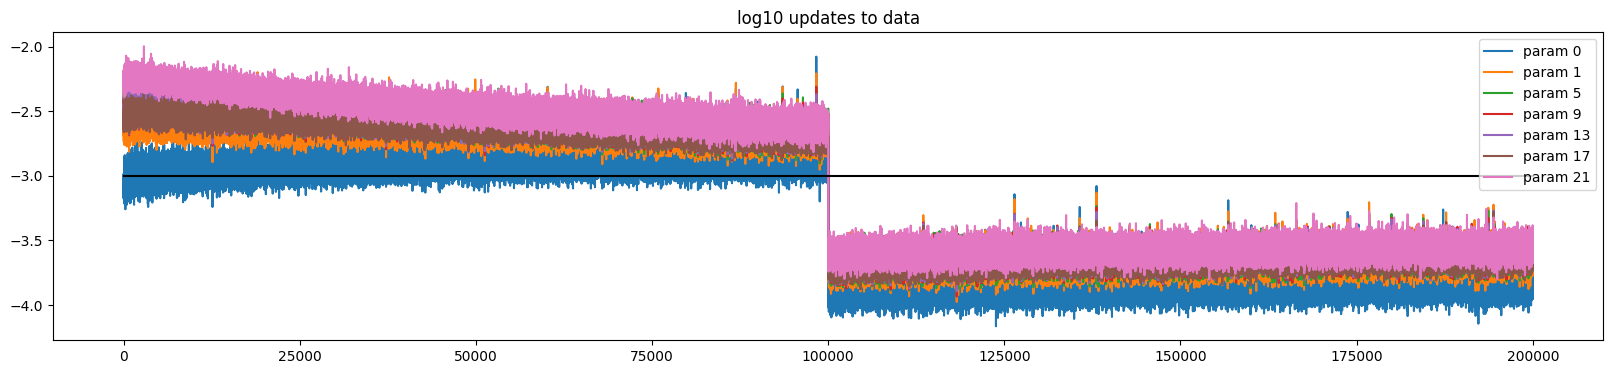

In [20]:
plt.figure(figsize=(20, 4))
legends = []
for i,p in enumerate(parameters):
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append(f'param {i}')
plt.plot([0, len(ud)], [-3, -3], 'k') # these ratios should be ~1e-3, indicate on plot
plt.legend(legends)
plt.title('log10 updates to data')